### Imports

In [13]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import scipy.stats as stats
import keras


## Dataset

In [179]:
y_power = 10
n_y = 2**y_power



data_list = list()
distributions = [stats.norm, stats.lognorm]
lims = [(10**-5,10**-5),(10**-5,10**-3)]
distrib_args = [list(),(1,)]


y_pdf = np.nan * np.ones((len(distributions),y_x.size))
for i, distribution, args, lim in zip(range(len(distributions)),distributions,distrib_args, lims):
    y_x = np.linspace(distribution.ppf(lim[0], *args), distribution.ppf(1-lim[1], *args), n_y)
    y = distribution.pdf(y_x, *args)
    y.reshape((1, y.size))    
    y_pdf[i,:] = y 
    
n_x = list(set([ j * 2**i for i in range(1,y_power) for j in (2,3,5)]))
n_x = np.array(n_x)
for n in n_x:   
    x_pdf = np.nan * np.ones((len(distributions),n))
    for i, distribution, args, lim in zip(range(len(distributions)),distributions,distrib_args, lims):
        x_x = np.linspace(distribution.ppf(lim[0],*args), distribution.ppf(1-lim[1],*args), n) 
        x_pdf[i,:] = distribution.pdf(x_x,*args)
        data_list.append((x_pdf, y_pdf))

<IPython.core.display.Javascript object>


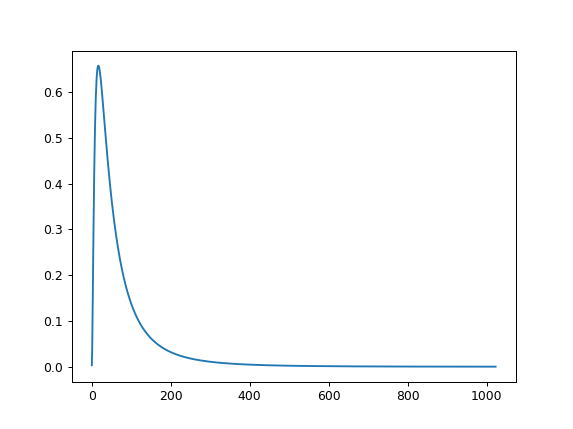

In [180]:
plt.figure()
plt.plot(data_list[0][1][1])

## Keras Model

In [91]:
keras.backend.clear_session()

n_a = 100

encoder_LSTM = keras.layers.LSTM(units = n_a, return_state=True)
decoder_LSTM = keras.layers.LSTM(units = n_a, return_sequences=True)

flatter = keras.layers.Flatten()
dense = keras.layers.Dense(units = 100, activation='tanh')
tanh_out = keras.layers.Dense(units = n_y, activation='tanh')

In [101]:
def define_model(n_a):
    
    x_input = keras.layers.Input(shape=(None, 1))
    
    _, encoder_h, encoder_c = encoder_LSTM(x_input)  
    
    decoder_input = keras.layers.Input(shape=(1,n_a))
    deco_input = decoder_input
    decoder_h = encoder_h
    decoder_c = encoder_c
    
    decoder_outputs = decoder_LSTM(deco_input, initial_state=[decoder_h, decoder_c])
    decoder_outputs_flat = flatter(decoder_outputs)
    out = dense(decoder_outputs_flat)
    out = tanh_out(out)
    
    
    model = keras.models.Model(inputs=[x_input, decoder_input], outputs=out)
    return model

In [102]:
model = define_model(n_a)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 1, 100)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 100), (None, 40800       input_6[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 1, 100)       80400       input_7[0][0]                    
                                                                 lstm_1[2][1]                     
          

In [115]:
optim = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optim, loss='mean_squared_error', metrics=['accuracy'])

In [120]:
decoder_in = np.zeros((1,1,n_a))
for x_pdf, y_pdf in data_list:
    model.fit(x=[x_pdf, decoder_in], y=y_pdf)

(128,)


ValueError: Error when checking input: expected input_6 to have 3 dimensions, but got array with shape (128, 1)